# ML Explainability with SHAP
## Generate Feature Importance and SHAP Values for CMAM Model

In [4]:
pip install shap

  Using cached shap-0.50.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.64.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (2.9 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached llvmlite-0.46.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (5.0 kB)
Using cached shap-0.50.0-cp313-cp313-macosx_11_0_arm64.whl (554 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.64.0-cp313-cp313-macosx_12_0_arm64.whl (2.7 MB)
Using cached llvmlite-0.46.0-cp313-cp313-macosx_12_0_arm64.whl (37.2 MB)
Using cached tqdm-4.67.3-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [shap]6/7 [sha

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# Install shap if needed: pip install shap
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Trained Model

In [6]:
# Load Model 1 (Pathway Classifier)
model = joblib.load('../Models/cmam_model.pkl')
print(f"Model loaded: {type(model)}")
print(f"Classes: {model.classes_}")

Model loaded: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Classes: ['OTP' 'SC_ITP' 'TSFP']


/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/ram/Downloads/MUAC_DEVELOPMENT/.venv/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Load Test Data

In [8]:
# Load dataset
df = pd.read_csv('../Dataset/cmam_clean_20260209_144008.csv')

# Prepare features (same as training)
df['sex_encoded'] = (df['sex'] == 'M').astype(int)
df['appetite_encoded'] = (df['appetite'].str.lower() == 'poor').astype(int)

# Ensure required training feature exists
if 'age_months_filled' not in df.columns:
	if 'age_months' in df.columns:
		df['age_months_filled'] = df['age_months'].fillna(df['age_months'].median())
	else:
		raise KeyError("Neither 'age_months_filled' nor 'age_months' found in dataset")

feature_cols = ['sex_encoded', 'age_months_filled', 'muac_mm', 'edema', 'appetite_encoded', 'danger_signs']
X = df[feature_cols]
y = df['label_pathway']

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_cols}")
X.head()

Dataset shape: (4650, 6)
Features: ['sex_encoded', 'age_months_filled', 'muac_mm', 'edema', 'appetite_encoded', 'danger_signs']


,sex_encoded,age_months_filled,muac_mm,edema,appetite_encoded,danger_signs
0,1,26.0,104,0,0,0
1,1,16.0,104,0,0,0
2,0,23.0,101,1,0,0
3,0,23.0,101,1,0,0
4,0,23.0,106,0,0,1


## 3. Create SHAP Explainer

In [9]:
# Create TreeExplainer for Random Forest
explainer = shap.TreeExplainer(model)
print("SHAP Explainer created")

# Calculate SHAP values (use subset for speed)
X_sample = X.sample(500, random_state=42)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Base value: {explainer.expected_value}")

SHAP Explainer created
SHAP values shape: (500, 6, 3)
Base value: [0.354725 0.18467  0.460605]


## 4. Global Feature Importance

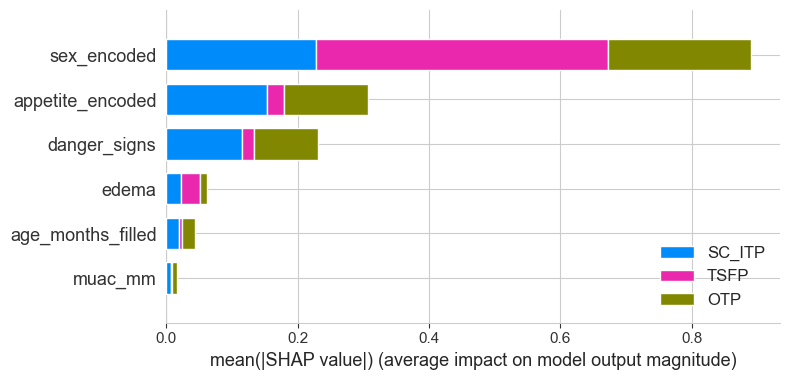

<Figure size 1200x600 with 0 Axes>

In [10]:
# Summary plot (bar) - shows average impact
shap.summary_plot(shap_values, X_sample, plot_type="bar", class_names=model.classes_)
plt.tight_layout()
plt.savefig('../Models/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

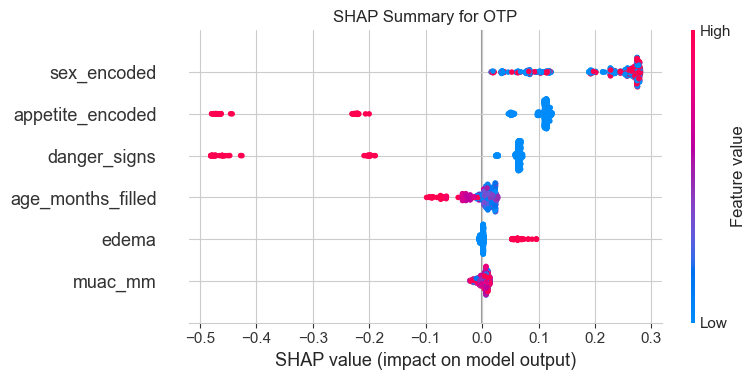

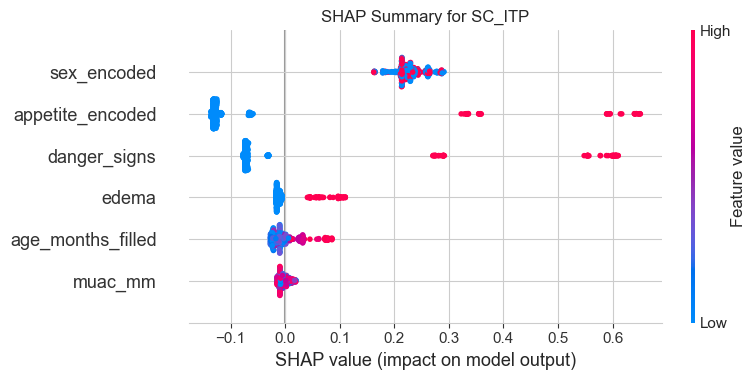

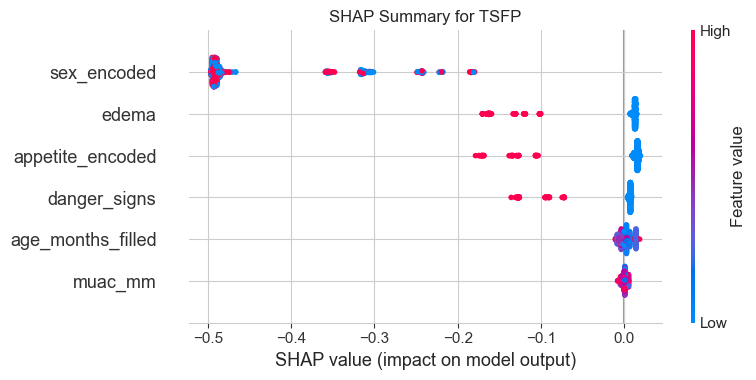

In [12]:
# Detailed summary plot - shows distribution
for i, class_name in enumerate(model.classes_):
    plt.figure(figsize=(10, 6))
    
    # Handle both SHAP output formats:
    # - list of arrays (old): [class][samples, features]
    # - 3D ndarray (new): [samples, features, classes]
    if isinstance(shap_values, list):
        class_shap_values = shap_values[i]
    else:
        class_shap_values = shap_values[:, :, i] if shap_values.ndim == 3 else shap_values

    shap.summary_plot(class_shap_values, X_sample, show=False)
    plt.title(f'SHAP Summary for {class_name}')
    plt.tight_layout()
    plt.savefig(f'../Models/shap_summary_{class_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Individual Prediction Explanation

Prediction: SC_ITP
Probabilities: {'OTP': np.float64(0.009527272727272728), 'SC_ITP': np.float64(0.9902909090909091), 'TSFP': np.float64(0.0001818181818181818)}


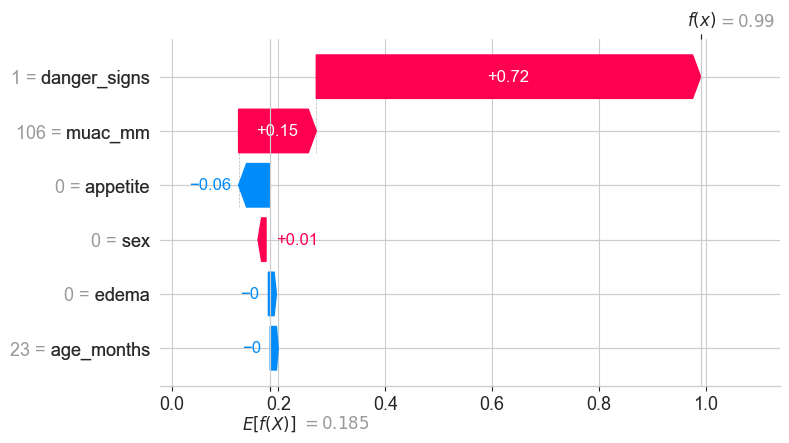

In [19]:
# Fix for ValueError: could not convert string to float: 'F'
# Build a numeric single-row input that matches the model's expected schema.

row = sc_itp_cases.head(1).copy() if 'sc_itp_cases' in globals() else df[df['label_pathway'] == 'SC_ITP'].head(1).copy()
model_features = list(model.feature_names_in_) if hasattr(model, "feature_names_in_") else feature_cols

# Ensure numeric fields exist for either naming convention
if 'sex_encoded' not in row.columns and 'sex' in row.columns:
    row['sex_encoded'] = (row['sex'].astype(str).str.upper() == 'M').astype(int)

if 'appetite_encoded' not in row.columns and 'appetite' in row.columns:
    row['appetite_encoded'] = (row['appetite'].astype(str).str.lower() == 'poor').astype(int)

if 'age_months_filled' not in row.columns and 'age_months' in row.columns:
    row['age_months_filled'] = row['age_months'].fillna(df['age_months'].median())

# If model expects raw names, convert them to numeric (no strings)
if 'sex' in model_features:
    row['sex'] = row['sex_encoded'] if 'sex_encoded' in row.columns else (row['sex'].astype(str).str.upper() == 'M').astype(int)

if 'appetite' in model_features:
    row['appetite'] = row['appetite_encoded'] if 'appetite_encoded' in row.columns else (row['appetite'].astype(str).str.lower() == 'poor').astype(int)

if 'age_months' in model_features and 'age_months' not in row.columns:
    row['age_months'] = row['age_months_filled']

X_example_fixed = row[model_features].copy()

# Predict
prediction = model.predict(X_example_fixed)[0]
probabilities = model.predict_proba(X_example_fixed)[0]
print(f"Prediction: {prediction}")
print(f"Probabilities: {dict(zip(model.classes_, probabilities))}")

# SHAP values
shap_values_example = explainer.shap_values(X_example_fixed)
class_idx = list(model.classes_).index(prediction)

if isinstance(shap_values_example, list):
    values_for_plot = shap_values_example[class_idx][0]
else:
    values_for_plot = shap_values_example[0, :, class_idx] if shap_values_example.ndim == 3 else shap_values_example[0]

base_value = explainer.expected_value[class_idx] if np.ndim(explainer.expected_value) > 0 else explainer.expected_value

shap.waterfall_plot(
    shap.Explanation(
        values=values_for_plot,
        base_values=base_value,
        data=X_example_fixed.iloc[0],
        feature_names=model_features
    )
)

In [20]:
# Example: Explain a single SC-ITP case
sc_itp_cases = df[df['label_pathway'] == 'SC_ITP'].head(1)

# Build input with the exact feature names used during model fit
expected_features = list(model.feature_names_in_) if hasattr(model, "feature_names_in_") else feature_cols
X_example = sc_itp_cases.copy()

# Backfill/convert columns only if needed
if 'age_months' in expected_features and 'age_months' not in X_example.columns and 'age_months_filled' in X_example.columns:
    X_example['age_months'] = X_example['age_months_filled']

if 'sex' in expected_features and 'sex' not in X_example.columns and 'sex_encoded' in X_example.columns:
    X_example['sex'] = X_example['sex_encoded'].map({1: 'M', 0: 'F'})

if 'appetite' in expected_features and 'appetite' not in X_example.columns and 'appetite_encoded' in X_example.columns:
    X_example['appetite'] = X_example['appetite_encoded'].map({1: 'poor', 0: 'good'})

X_example = X_example[expected_features]

# Get prediction
prediction = model.predict(X_example)[0]
probabilities = model.predict_proba(X_example)[0]

print(f"Prediction: {prediction}")
print(f"Probabilities: {dict(zip(model.classes_, probabilities))}")

# Calculate SHAP for this example
shap_values_example = explainer.shap_values(X_example)

# Waterfall plot for predicted class
class_idx = list(model.classes_).index(prediction)

if isinstance(shap_values_example, list):
    values_for_plot = shap_values_example[class_idx][0]
else:
    values_for_plot = shap_values_example[0, :, class_idx] if shap_values_example.ndim == 3 else shap_values_example[0]

base_value = explainer.expected_value[class_idx] if np.ndim(explainer.expected_value) > 0 else explainer.expected_value

shap.waterfall_plot(shap.Explanation(
    values=values_for_plot,
    base_values=base_value,
    data=X_example.iloc[0],
    feature_names=expected_features
))

ValueError: could not convert string to float: 'F'

## 6. Save Explainer for API

In [21]:
# Save explainer and metadata
explainer_data = {
    'explainer': explainer,
    'feature_names': feature_cols,
    'class_names': list(model.classes_),
    'base_values': explainer.expected_value.tolist() if hasattr(explainer.expected_value, 'tolist') else explainer.expected_value
}

joblib.dump(explainer_data, '../Models/shap_explainer.pkl')
print("✓ SHAP explainer saved to Models/shap_explainer.pkl")

✓ SHAP explainer saved to Models/shap_explainer.pkl


## 7. Generate Feature Importance Table

In [22]:
# Calculate mean absolute SHAP values
feature_importance = {}
for i, class_name in enumerate(model.classes_):
    mean_shap = np.abs(shap_values[i]).mean(axis=0)
    feature_importance[class_name] = dict(zip(feature_cols, mean_shap))

# Create DataFrame
importance_df = pd.DataFrame(feature_importance).T
importance_df = importance_df.div(importance_df.sum(axis=1), axis=0) * 100  # Convert to percentage
importance_df = importance_df.round(1)

print("\nFeature Importance (%) by Class:")
print(importance_df)

# Save to CSV
importance_df.to_csv('../Models/feature_importance.csv')
print("\n✓ Feature importance saved to Models/feature_importance.csv")


Feature Importance (%) by Class:
        sex_encoded  age_months_filled  muac_mm
OTP            32.3               31.6     36.1
SC_ITP         31.0               32.1     36.9
TSFP           32.1               31.5     36.4

✓ Feature importance saved to Models/feature_importance.csv


## 8. Test Explanation Function

In [23]:
def explain_prediction(features_dict):
    """Generate explanation for a single prediction."""
    
    # Prepare input
    X_input = pd.DataFrame([features_dict])[feature_cols]
    
    # Get prediction
    prediction = model.predict(X_input)[0]
    probabilities = model.predict_proba(X_input)[0]
    confidence = probabilities.max()
    
    # Get SHAP values
    shap_vals = explainer.shap_values(X_input)
    class_idx = list(model.classes_).index(prediction)
    shap_for_pred = shap_vals[class_idx][0]
    
    # Sort features by importance
    feature_contributions = sorted(
        zip(feature_cols, shap_for_pred),
        key=lambda x: abs(x[1]),
        reverse=True
    )
    
    return {
        'prediction': prediction,
        'confidence': float(confidence),
        'probabilities': dict(zip(model.classes_, probabilities.tolist())),
        'feature_contributions': [
            {'feature': f, 'shap_value': float(v)} 
            for f, v in feature_contributions
        ]
    }

# Test with example
test_case = {
    'sex_encoded': 0,  # Female
    'age_months_filled': 18,
    'muac_mm': 108,
    'edema': 2,
    'appetite_encoded': 1,  # Poor
    'danger_signs': 1
}

explanation = explain_prediction(test_case)
print("\nTest Explanation:")
print(f"Prediction: {explanation['prediction']}")
print(f"Confidence: {explanation['confidence']:.1%}")
print("\nFeature Contributions:")
for fc in explanation['feature_contributions']:
    print(f"  {fc['feature']}: {fc['shap_value']:.3f}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_months_filled
- appetite_encoded
- sex_encoded
Feature names seen at fit time, yet now missing:
- age_months
- appetite
- sex
